In [1311]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error


matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [1312]:
snp = pd.read_csv("../selfstudy/study_data/snp500_history.csv")

In [1313]:

# fig, ax = plt.subplots(1,3, figsize=(10,4))

# sns.scatterplot(data=for_graph,
#                 x="Close",
#                 y="Close_rag_2100",
#                 color = "tab:blue",
#                 alpha = 0.3,
#                 ax= ax[0])

# sns.scatterplot(data=for_graph,
#                 x="Close",
#                 y="Close_rag_7100",
#                 color = "tab:orange",
#                 alpha = 0.3,
#                 ax = ax[1])

# sns.scatterplot(data=for_graph,
#                 x="Close",
#                 y="Close_rag_17100",
#                 color = "tab:purple",
#                 alpha = 0.3,
#                 ax = ax [2])


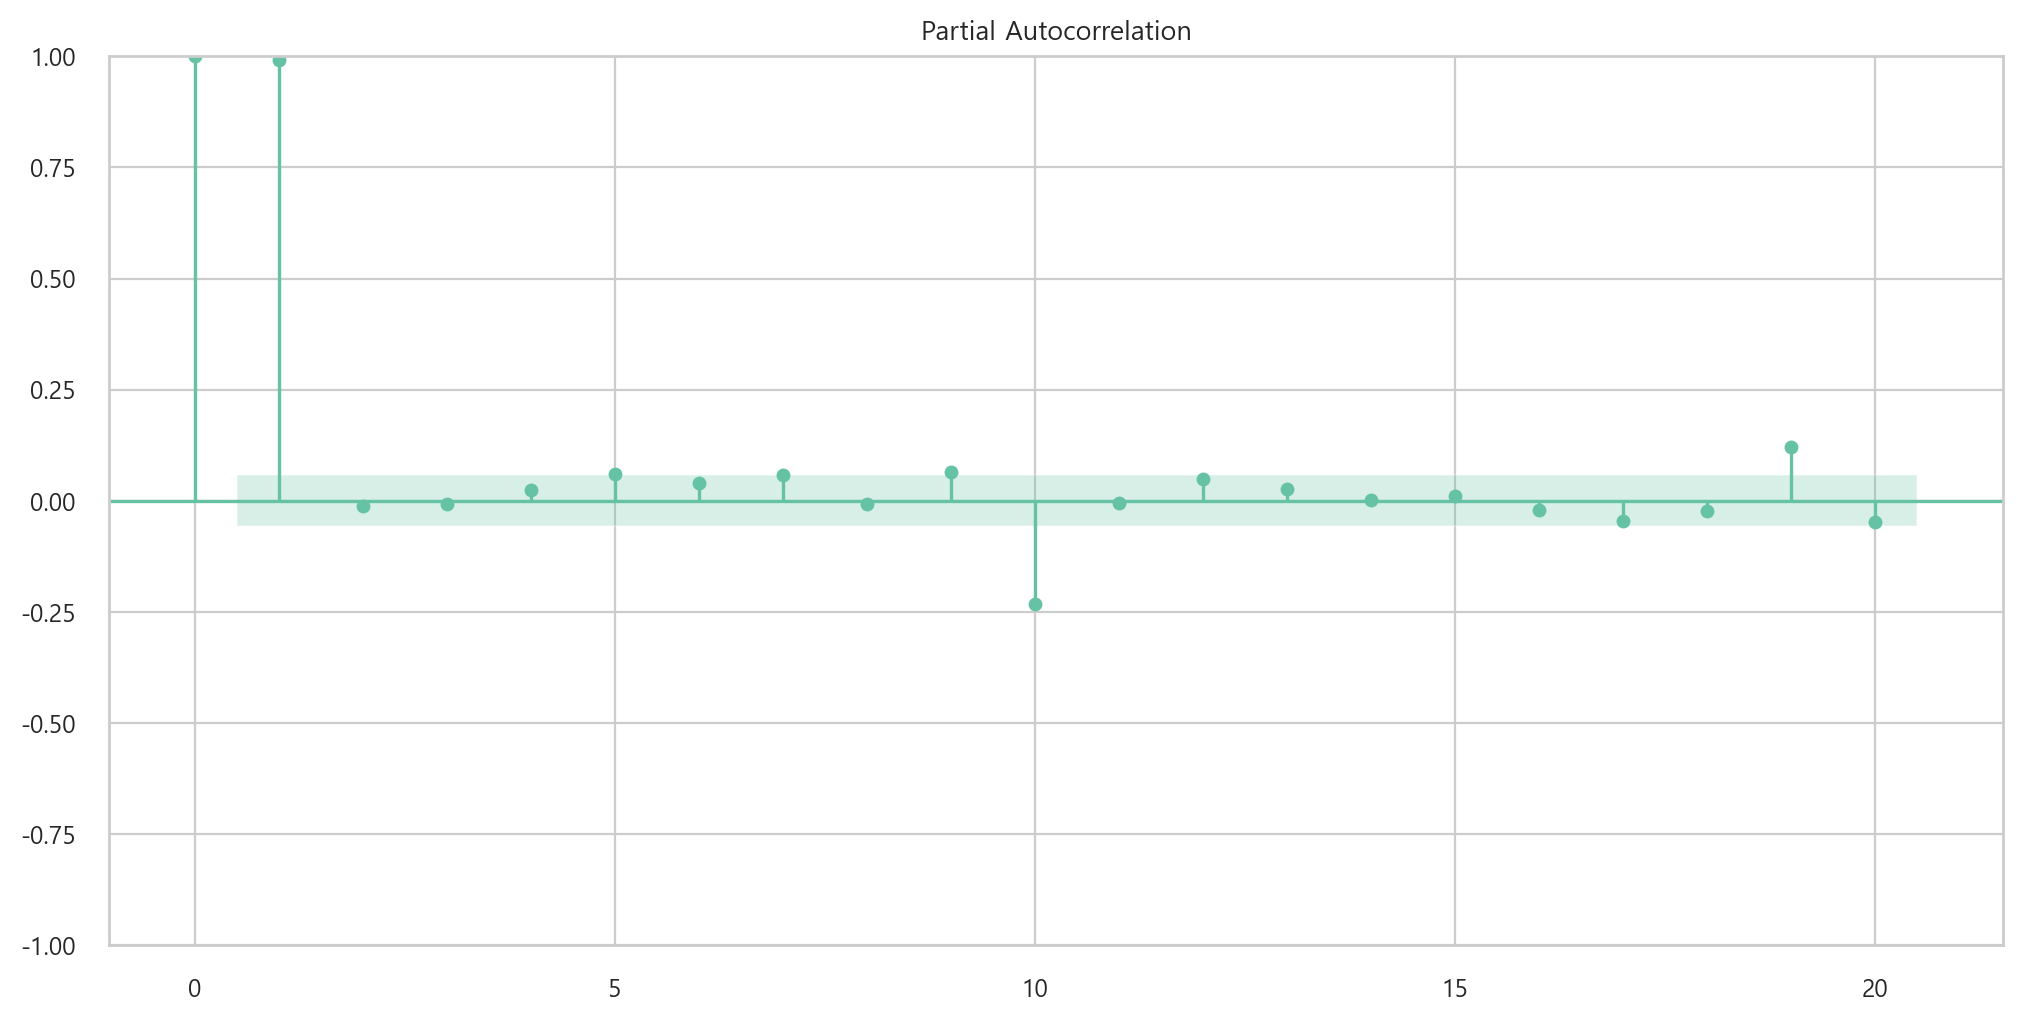

In [1314]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

snp_20 = snp.iloc[0:-1:20] # 주말빼고 약 한달에 20일정도씩

fig, ax = plt.subplots(1,1, figsize=(10,5))

plot_pacf(snp_20['Close'], lags=20, ax=ax);

In [1315]:
new_snp = snp_20[["Close"]].copy()
new_snp["lag_1"] = new_snp["Close"].shift(1)
new_snp["lag_10"] = new_snp["Close"].shift(10)
new_snp["lag_19"] = new_snp["Close"].shift(19)

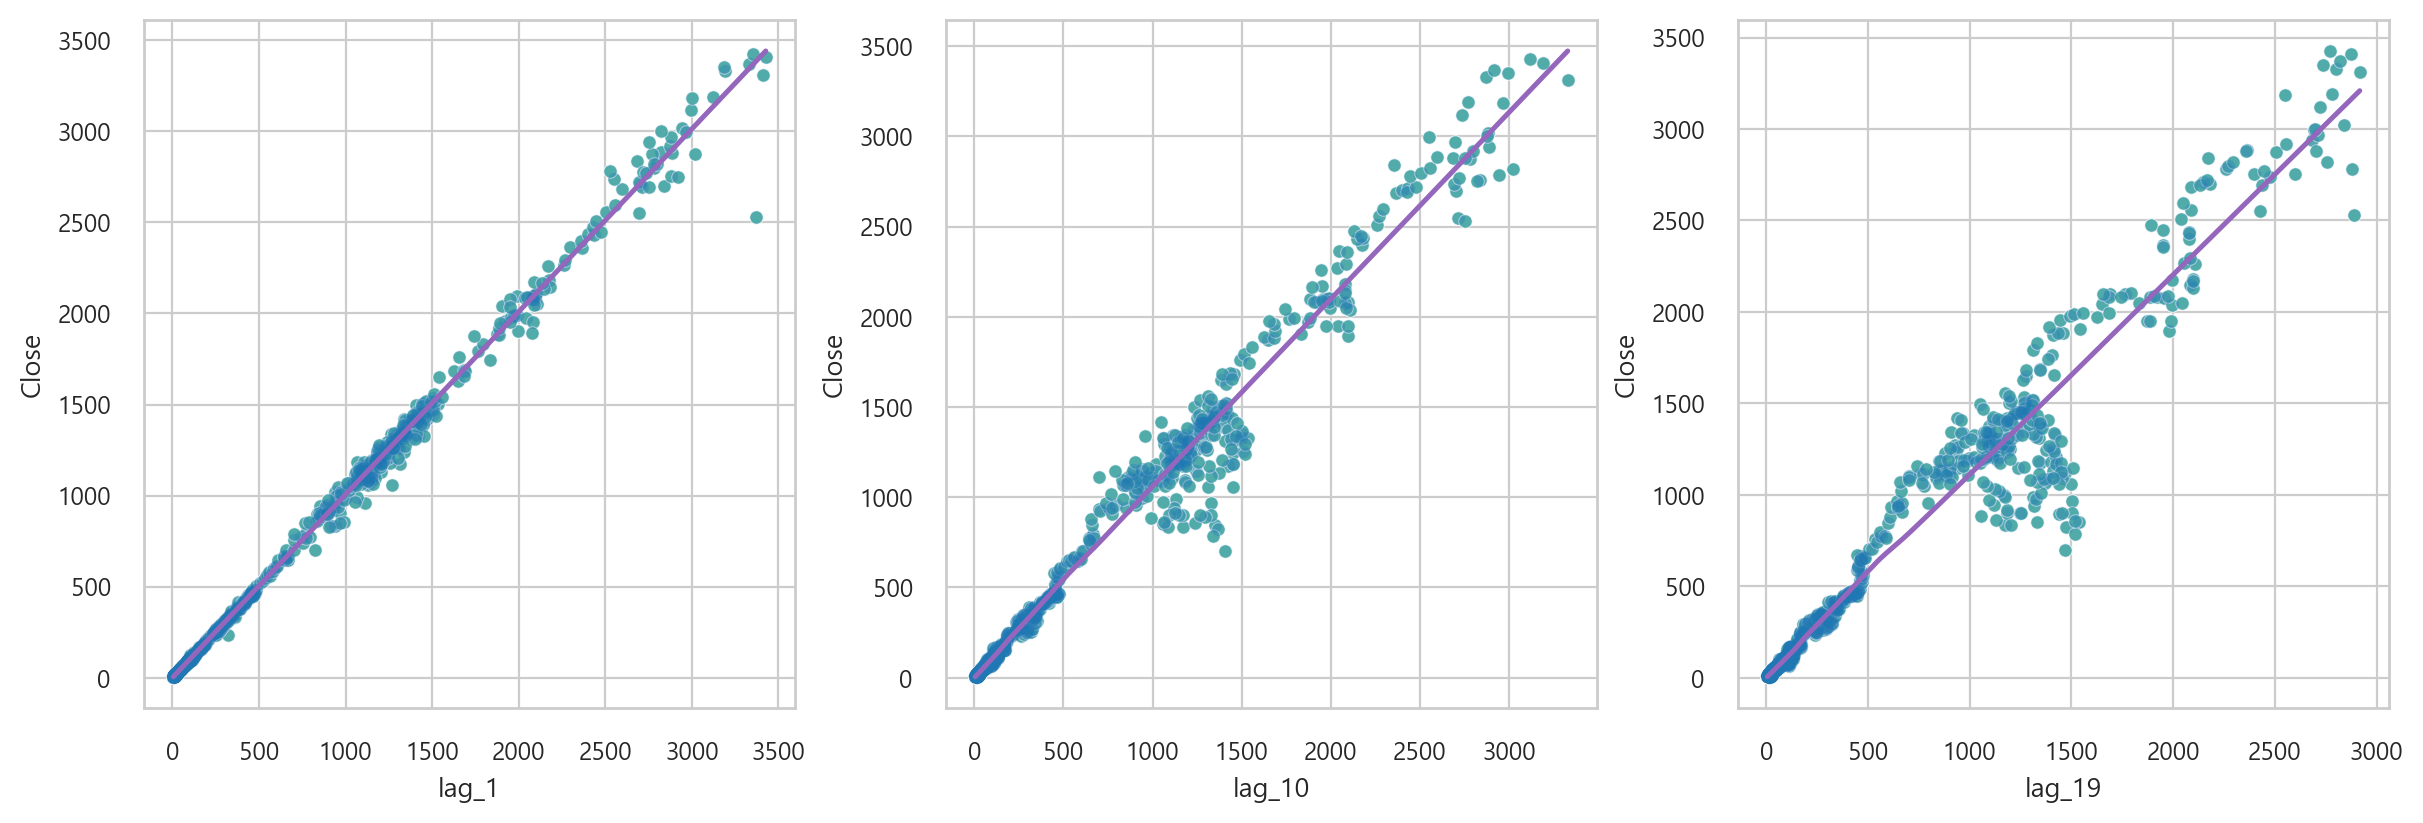

In [1316]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
lags = [1,10,19]

for i in range(len(lags)):
    sns.scatterplot(data=new_snp,
                    x="lag_" + str(lags[i]),
                    y="Close",
                    ax=ax[i])
    
    sns.regplot(data=new_snp,
                    x="lag_" + str(lags[i]),
                    y="Close",
                    scatter_kws={"color": "tab:blue", "alpha": 0.3},
                    color = "tab:purple",
                    lowess=True,
                    ax=ax[i],)

In [1317]:
new_snp.dropna(inplace=True)

In [1318]:
X = new_snp.drop(columns=["Close"])
y = new_snp["Close"]

In [1319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)

In [1320]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1128, 3)
(20, 3)
(1128,)
(20,)


In [1321]:
# 1. lag 피쳐의 모델 (lag_1, lag_10, lag_19)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, test_size=20, shuffle=False)

model_f = LinearRegression()
model_f.fit(X_train, y_train)
y_pred_2 = pd.Series(model_f.predict(X_train_f), index=y_train_f.index)
y_fore_2 = pd.Series(model_f.predict(X_test_f), index=y_test_f.index)

### 이동평균선

In [1322]:
# 2. 이동 평균선 + 피쳐 (lag_1, moving_mean)
new_snp["moving_mean"] = new_snp["Close"].rolling(window=5,center=True).mean()
new_snp.dropna(axis=0, inplace=True)

X = new_snp.drop(columns=["Close"])
y = new_snp["Close"]

X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X[["lag_1","moving_mean"]], y, test_size=20, shuffle=False)

model_mm = LinearRegression()
model_mm.fit(X_train_mm, y_train_mm)
y_pred_3 = pd.Series(model_mm.predict(X_train_mm), index=y_train_mm.index)
y_fore_3 = pd.Series(model_mm.predict(X_test_mm), index=y_test_mm.index)

In [1323]:
# 3. 이동 평균선만으로 (moving_mean)
X_train_mm_2, X_test_mm_2, y_train_mm_2, y_test_mm_2 = train_test_split(X[["moving_mean"]], y, test_size=20, shuffle=False)

model_mm = LinearRegression()
model_mm.fit(X_train_mm_2, y_train_mm_2)
y_pred_4 = pd.Series(model_mm.predict(X_train_mm_2), index=y_train_mm_2.index)
y_fore_4 = pd.Series(model_mm.predict(X_test_mm_2), index=y_test_mm_2.index)

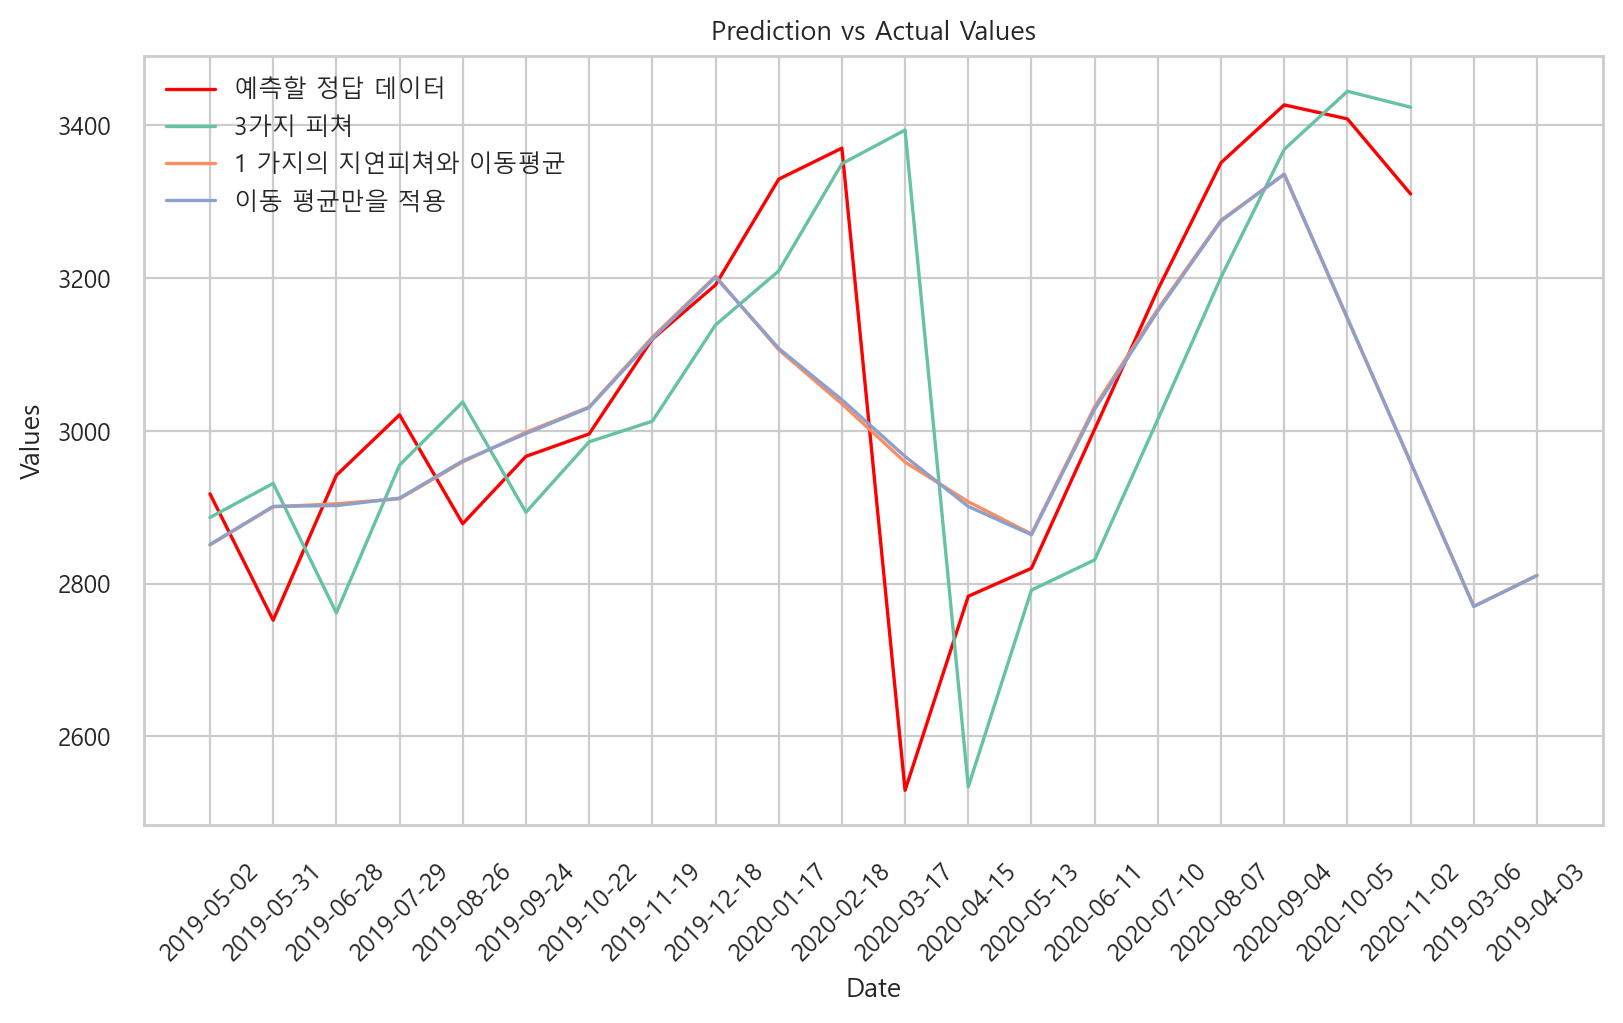

In [1324]:
fig, ax = plt.subplots(1,1, figsize=(8,5))


sns.lineplot(x=snp_20["Date"].loc[y_test.index],
             y=y_test,
             color="red",
             label="예측할 정답 데이터",)

sns.lineplot(x=snp_20["Date"].loc[y_fore_2.index],
             y=y_fore_2,
             label="3가지 피쳐",)

sns.lineplot(x=snp_20["Date"].loc[y_fore_3.index],
             y=y_fore_3,
             label="1 가지의 지연피쳐와 이동평균",)

sns.lineplot(x=snp_20["Date"].loc[y_fore_4.index],
             y=y_fore_4,
             label="이동 평균만을 적용",)

ax.set(xlabel='Date', ylabel='Values', title = "Prediction vs Actual Values")
plt.xticks(rotation=45);

In [1325]:
print("""\
3종의 시간지연 MSE : {:0.2f}
이동평균  MSE : {:0.2f}
이동평균과 1종의 시간 지연 MSE : {:0.2f}\
""".format(
mean_squared_error(y_test_f,y_fore_2),
mean_squared_error(y_test_mm_2,y_fore_4),
mean_squared_error(y_test_mm,y_fore_3),
))

3종의 시간지연 MSE : 51960.70
이동평균  MSE : 21661.19
이동평균과 1종의 시간 지연 MSE : 21629.98
